# Part 1 Classification with MLP updated by Backpropagation following Gradient Descent
### **Part 1a. Data Generation and Display**<br>
The scatter plot generated by the given code is shown as below.

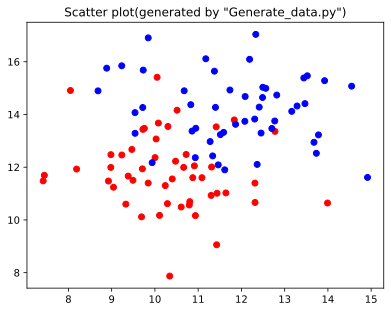

In [350]:
# For better display: figures are displayed as svg
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# import libraries:
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler

# Part 1a. Data generation (from the provided code)
N1 = 50
N2 = 50
sigma = 2
mean1 = (10, 12)
cov1 = [[sigma, 0], [0, sigma]]
X1 = np.random.multivariate_normal(mean1, cov1, N1)
c1 = ['red'] * len(X1)

mean2 = (12, 14)
cov2 = [[sigma, 0], [0, sigma]]
X2 = np.random.multivariate_normal(mean2, cov2, N2)
c2 = ['blue'] * len(X2)

X = np.concatenate((X1, X2))
color = np.concatenate((c1, c2))
y = np.array([0] * N1 + [1] * N2).reshape(-1, 1)

# show and save dataset
plt.scatter(X[:, 0], X[:, 1], marker = 'o', c = color)
plt.title('Scatter plot(generated by "Generate_data.py")')
plt.show()

np.save('class1.npy', X1)
np.save('class2.npy', X2)
io.savemat('class1.mat', {'class1': X1})
io.savemat('class2.mat', {'class2': X2})

### **Part 2b. Initialize MLP Network Framework**<br>
1. I select **Leaky-ReLU** function as activation functions for the hidden layer and and **Sigmoid** function for the output layer.
2. Define a class `MLP` to implement MLP classifier: initialize the weights and biases randomly (`__init__`:using a normal distrubution to pick random numbers) and calculate the outputs of the hidden layer and output layer(`forward` function).
3. Plot the initial decision boundary(`plot_decision_boundary`) and print the initial accuracy.

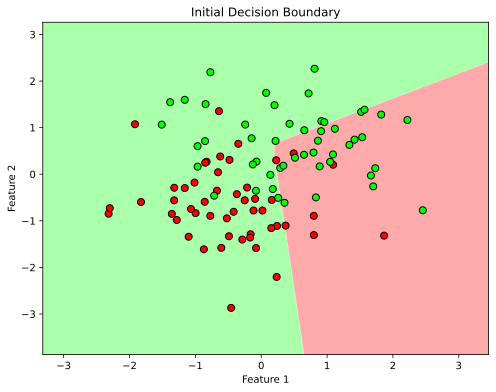

Classification Accuracy Before Training: 33.00%


In [351]:
# Part 1b. implement of a multi-layer perceptron (MLP) for classification:
# Data Standardization
scaler = StandardScaler()
X_mlp = scaler.fit_transform(X)

# Leaky ReLU activation function
def leaky_relu(x):
    return np.where(x > 0, x, 0.01 * x)

def leaky_relu_derivative(x):
    return np.where(x > 0, 1, 0.01)

# Sigmoid and its derivative
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Binary cross-entropy loss (used to update the weights of MLP in Part 1c)
def binary_cross_entropy(y_true, y_pred):
    epsilon = 1e-9
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    # In order to avoid numerical instabilities or mathematical errors when calculating logarithms, I add 1e-9 into the across entropy formula.

# MLP Class with Regularization
class MLP:
    def __init__(self, reg_lambda=0.001):
        self.reg_lambda = reg_lambda
        # Initialize weights randomly with normal distribution
        self.weights_input_hidden = np.random.randn(2, 3)
        self.weights_hidden_output = np.random.randn(3, 1)
        self.bias_hidden = np.random.randn(1, 3)
        self.bias_output = np.random.randn(1, 1)

    def forward(self, X):
        # Forward pass
        self.hidden_layer_input = np.dot(X, self.weights_input_hidden) + self.bias_hidden
        self.hidden_layer_output = leaky_relu(self.hidden_layer_input)
        self.output_layer_input = np.dot(self.hidden_layer_output, self.weights_hidden_output) + self.bias_output
        self.output_layer_output = sigmoid(self.output_layer_input)
        return self.output_layer_output

    def predict(self, X):
        # Generate binary predictions
        output = self.forward(X)
        predictions = (output > 0.5).astype(int)
        return predictions

    # Backpropagation (used to update the weights of MLP in Part 1c)
    def backpropagate(self, X, y, learning_rate=0.01):
        # Forward pass
        output = self.forward(X)
        
        # Compute output error and its gradient
        output_error = output - y
        output_delta = output_error * sigmoid_derivative(self.output_layer_input)

        # Compute hidden layer error and its gradient
        hidden_error = np.dot(output_delta, self.weights_hidden_output.T)
        hidden_delta = hidden_error * leaky_relu_derivative(self.hidden_layer_output)

        # L2 Regularization term(prevent overfitting)
        reg_term_input_hidden = self.reg_lambda * self.weights_input_hidden
        reg_term_hidden_output = self.reg_lambda * self.weights_hidden_output

        # Update weights and biases with gradient descent + regularization
        self.weights_hidden_output -= learning_rate * (np.dot(self.hidden_layer_output.T, output_delta) + reg_term_hidden_output)
        self.weights_input_hidden -= learning_rate * (np.dot(X.T, hidden_delta) + reg_term_input_hidden)
        self.bias_output -= learning_rate * np.sum(output_delta, axis=0)
        self.bias_hidden -= learning_rate * np.sum(hidden_delta, axis=0)

        # Calculate and return the binary cross-entropy loss for monitoring
        loss = binary_cross_entropy(y, output)
        return loss


# Plot function:
def plot_decision_boundary(model, X, y, title):
    # Generate a grid and predict class:
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    #define class colors:
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

    # Plot decision boundary
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cmap_light)
    plt.scatter(X[:, 0], X[:, 1], c=y.flatten(), cmap=cmap_bold, edgecolor='k', s=50)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.show()

# Initialize the MLP
mlp = MLP(reg_lambda=0.01)
# Plot the initial decision boundary before training
plot_decision_boundary(mlp, X_mlp, y, 'Initial Decision Boundary')
predictions_init = mlp.predict(X_mlp)
accuracy_init = np.mean(predictions_init == y)
print(f"Classification Accuracy Before Training: {accuracy_init * 100:.2f}%")

**Accuracy Before training**<br>
Notice that the decision boundary does not align with the true separation of the data and accuracy is relatively low since no training performed yet. The randomly selected weights lead to poor performance.

### **Part 1c. Backpropagate to Update the Weights of MLP**<br>
1. In order to get better decision boundary we need to update the parameters by backpropagation(`backpropagate` in class `MLP`, code is shown in Part 1b already), using the gradient descent method.
2. Select binary cross entropy as the loss function(`binary_cross_entropy`, code is shown in Part 1b already).
3. 500 epochs were trained, and each epoch updated the weights and biases of the network with backpropagation, loss curve is shown below.
4. Once the training is complete, the MLP output the final decision boundary and classification accuracy.<br>

I will explain my code specifically:<br>
**1. Backpropagation**<br>
The error is calculated by subtracting the model output from the true label (`output_error`). <br>
The gradient of the output is calculated using the derivative of the sigmoid activation function (`sigmoid_derivative`).<br>
The error is backpropagated to the hidden layer, and the weights are updated using gradient descent.<br>

**2. Gradient Descent**<br>
Weights and biases are updated by a gradient of errors. The basic formula for the gradient descent method is as follows：
$$W_{new} = W_{old} + \eta \cdot \frac{\partial L}{\partial W}$$
$W_{\text{old}}$ is the old weight,<br>
$\eta$ is the learning rate,<br>
$\frac{\partial L}{\partial W}$ is the partial derivative of the loss function with respect to the weights.<br>
$L$ is the loss function, which is Binary Cross-Entropy here.
$$
L = - \frac{1}{n} \sum_{i=1}^{n} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
$$
When the output layer uses the sigmoid activation function, the derivative of the cross-entropy loss can be reduced to the difference between the predicted value and the true value. So we use `output_error = output - y` to update the weights of the network.

**3. L2 Regularization**<br>
Adding regularization, such as L2 regularization, can help make weight updates smoother and avoid overfitting.<br>

**4. Accuracy**<br>
$$
\text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}}
$$
`np.mean(predictions_init == y)` calculate this ratio.


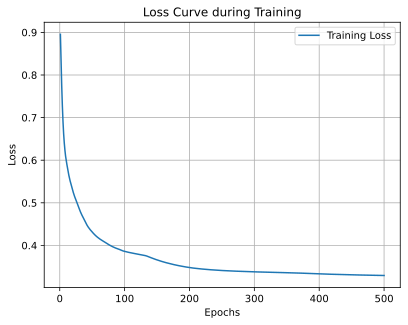

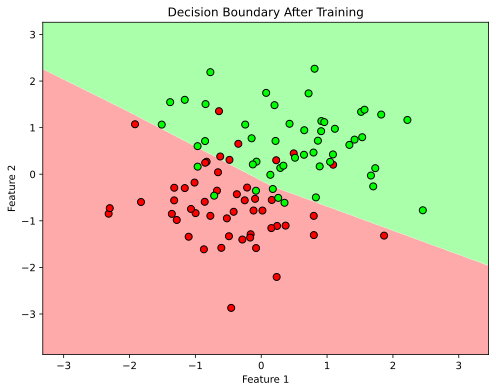

Classification Accuracy After Training: 87.00%


In [352]:
# Part 1c. Update the weights by backpropagation algorithm and plot the new decision boundary
# Train the MLP using backpropagation
epochs = 500
learning_rate = 0.01
loss_history = []
for epoch in range(epochs):
    loss = mlp.backpropagate(X_mlp, y, learning_rate)
    loss_history.append(loss)
    # print(f'[{epoch}/{epochs}] loss:{loss:.4f}%, ')
    

# Plot the loss after training
plt.plot(range(1, epochs + 1), loss_history, label='Training Loss')  # Use 'epochs' here
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve during Training')
plt.grid(True)
plt.legend()
plt.show()

# Plot the decision boundary after training
plot_decision_boundary(mlp, X_mlp, y, 'Decision Boundary After Training')

# Calculate classification accuracy
predictions = mlp.predict(X_mlp)
accuracy = np.mean(predictions == y)
print(f"Classification Accuracy After Training: {accuracy * 100:.2f}%")

**Comparation**<br>
The accuracy is improved significantly from 33% to 87%. <br>
Before training, the decision boundary is random because the weights are randomly initialized. <br>
After training the MLP for 500 epochs using backpropagation, MLP classifier adjusts the decision boundary to separate the two classes better.


# Part 2 Classification with RBF Network with Random RBF Centers
### Part 2a. RBF Network with 3 Random RBF Centers
In this part, I implemented RBF network from scratch:<br>

1. `rbf_function`: Compute the distance between data and selected center. The activation function of RBF network is a Gaussian function with the following formula:
$$
\text{rbf}(x, c, \sigma) = \exp \left( - \frac{\|x - c\|^2}{2 \sigma^2} \right)
$$
where<br>
$x$ is the input data point,<br>
$c$ is the center of the RBF (chosen randomly),<br>
$\sigma$ is the width parameter (how wide or narrow the Gaussian is).<br>


2. `select_rbf_centers`: Ramdonly select the RBF centers from dataset, and the centers will be use in the **hidden layer**.

3. `compute_design_matrix`: Compute the outputs of the RBF functions, for each input sample, we compute the `rbf_function` for all centers and store them in a **design matrix**.

4. `train_rbf_network`: Minimize the **Mean Squared Error(MSE)** between the predictions and the target labels to update the weights between the hidden layer and the output. Loss function is MSE:
$$ 
L = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$
where <br>
$y_i$ is the groundtruth label,<br>
$\hat{y}_i$ is the prediction of model.<br>
Train the RBF Network(using Least Squares Estimation) by solving:
$$ 
w = (\Phi^T \Phi + \lambda I)^{-1} \Phi^T y
$$
where<br>
$\Phi$ is the design matrix,<br>
$\lambda$ is the regularization term (L2 regularization to prevent overfitting),<br>
$w$ are the weights between the hidden layer and the output layer.<br>

5. `rbf_predict`: Make predictions by computing the output of the hidden layer for new input data then apply the trained wights, finally threshold the output at 0.5.


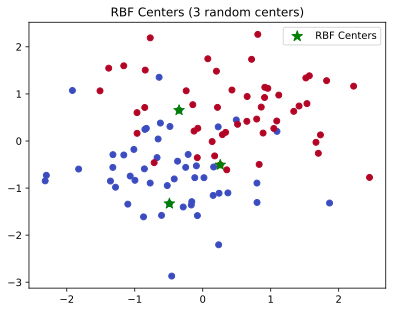

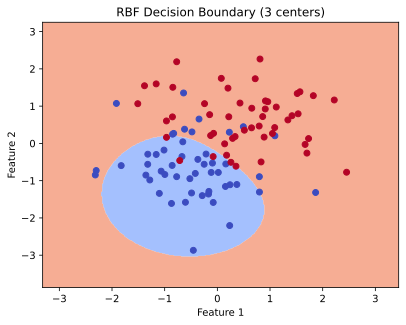

Accuracy:80.0%




In [353]:
# Part 2 RBF layer
# Part 2a RBF Network with 3 Random RBF Centers

# Data has been generated in Part 1: X, y
# # Data standardization
scaler = StandardScaler()
X_rbf = scaler.fit_transform(X)

# Gaussian RBF function
def rbf_function(x, center, sigma):
    return np.exp(-np.linalg.norm(x - center, axis=1) ** 2 / (2 * sigma ** 2))

# Randomly select RBF centers
def select_rbf_centers(X, num_centers):
    indices = np.random.choice(X.shape[0], num_centers, replace=False)
    centers = X[indices]
    return centers

# Construct the design matrix for the RBF network
def compute_design_matrix(X, centers, sigma):
    design_matrix = np.zeros((X.shape[0], len(centers)))
    for i, center in enumerate(centers):
        design_matrix[:, i] = rbf_function(X, center, sigma)
    return design_matrix

# Train the RBF network using LS Estimation
def train_rbf_network(X, y, num_centers, sigma, l2_lambda=0.01):
    # Randomly select RBF centers
    centers = select_rbf_centers(X, num_centers)
    
    # Construct the design matrix
    design_matrix = compute_design_matrix(X, centers, sigma)
    
    # Add bias term (column of ones)
    design_matrix = np.hstack([np.ones((design_matrix.shape[0], 1)), design_matrix])
    
    # Solve weights using least squares estimation (with L2 regularization)
    reg_matrix = l2_lambda * np.identity(design_matrix.shape[1])
    weights = np.linalg.inv(design_matrix.T @ design_matrix + reg_matrix) @ design_matrix.T @ y
    
    return centers, weights

# Predict function for RBF network
def rbf_predict(X, centers, weights, sigma):
    # Compute the design matrix for prediction
    design_matrix = compute_design_matrix(X, centers, sigma)
    design_matrix = np.hstack([np.ones((design_matrix.shape[0], 1)), design_matrix])  # Add bias term
    predictions = design_matrix @ weights
    return predictions >= 0.5  # Threshold at 0.5 for binary classification    

# Corrected decision boundary plot function
def plot_decision_boundary_rbf(centers, weights, X, y, sigma, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.02  # Step size for the grid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Create a grid of values and scale the grid
    grid = np.c_[xx.ravel(), yy.ravel()]
    # grid_scaled = scaler.transform(grid)
    
    # Predict values for the grid
    Z = rbf_predict(grid, centers, weights, sigma).reshape(xx.shape)
    
    # Plotting the decision boundary
    # plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], cmap='coolwarm', alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()


def RBF_test(X, y, sigma_rbf, num_centers, l2_lambda):
    # Train the RBF network
    centers, weights = train_rbf_network(X, y, num_centers=num_centers, sigma=sigma_rbf, l2_lambda=l2_lambda)

    # Highlight the RBF centers
    plt.scatter(X[:, 0], X[:, 1], c=y.flatten(), cmap='coolwarm')
    plt.scatter(centers[:, 0], centers[:, 1], c='green', marker='*', label='RBF Centers', s=120)
    plt.legend()
    plt.title(f'RBF Centers ({num_centers} random centers)')
    plt.show()

    # Plot the decision boundary
    plot_decision_boundary_rbf(centers, weights, X, y, sigma_rbf, f'RBF Decision Boundary ({num_centers} centers)')
    
    # Compute accuracy
    y_pred = rbf_predict(X, centers, weights, sigma_rbf)
    accuracy = np.mean(y_pred == y) * 100
    print(f'Accuracy:{accuracy}%\n\n')

# Parameters
sigma_rbf = 1
num_centers = 3
l2_lambda = 0.01
# Test the RBF network
RBF_test(X_rbf, y, sigma_rbf, num_centers, l2_lambda)

**Compared with updated MLP**<br>
1. **Decision Boundary**:<br>
The decision boundary of RBF network is nonlinear while that of MLP is somewhat linear.<br>

2. **Accuracy**: <br>
The RBF Network with 3 random centers may have a lower accuracy than the updated MLP. The underlying reasons could be: <br>
(1) Validity of the selection of RBF centers<br>Currently we randomly select 3 points in the data as RBF centers, which may not be sufficient to represent the data distribution well. Further, we can consider using a clustering algorithm such as K-Means to select RBF hubs to ensure that the hubs are more appropriately distributed across the data space.<br>
(2) Insufficient nonlinear mapping of the feature space<br>Only 3 RBF neurons may not be able to capture the complexity of the data. Increasing the number of RBF neurons will help improve the expressiveness of the model.

### Part 2b. Repeat Part 2a, now with 6 RBF centers that are randomly set
In this part, I only change the number of RBF centers from 3 to 6.<br>

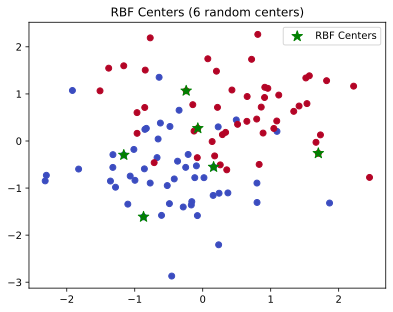

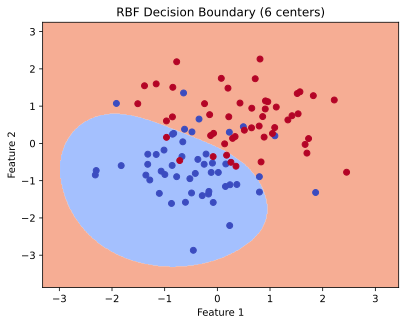

Accuracy:84.0%




In [354]:
# Part 2b
# Now we just change the number of centers from 3 to 6
num_centers = 6
# Test the RBF network
RBF_test(X_rbf, y, sigma_rbf, num_centers, l2_lambda)


**Comparation with Part 2a:**<br>
1. In most cases, the accuracy does increase as we increase the number of random centers. As suggested in Part 2a, increasing the number of RBF neurons will help improve the expressiveness of the model and extract the features of data.
2. But accuracy does not necessarily increase because the performance of the RBF network is highly dependent on the choice of hubs, and if the randomly selected hubs fail to effectively cover the data space, the model performance may be degraded.
3. Increasing RBF centers also presents some challenges, such as the risk of overfitting. If the number of centers is too large, the model may overfit the training data, resulting in degraded generalization performance.